In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import statsmodels.api as sm
%matplotlib inline
from datetime import date, timedelta
from pandas.plotting import scatter_matrix
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoRegResults

# Assignment 1 
## Overview

In [2]:
# Define population figures for Germany, China and the US 
POPULATION_GERMANY = 83783942
POPULATION_CHINA = 1439323776
POPULATION_US = 331002651

In [3]:
# Load the time-series dataframe, downloaded from see Reference 6
df= pd.read_csv('countries-aggregated_csv.csv')

In [4]:
# Extract data for Germany
df_Germany = df[df["Country"] == "Germany"].reset_index()
df_Germany = df_Germany.drop(['index'], axis=1)

In [5]:
# Extract data for China
df_China = df[df["Country"] == "China"].reset_index()
df_China = df_China.drop(['index'], axis=1)

In [6]:
# Extract data for the US
df_US = df[df["Country"] == "US"].reset_index()
df_US = df_US.drop(['index'], axis=1)

In [7]:
# Creates a Dataframe
def create_df(column):
    return pd.concat([df_Germany["Date"], df_Germany[column], df_China[column], 
                        df_US[column]], axis=1, keys=['Date', 'Germany', 'China', 'US'])

# Formats the date-column to display months on the x-axis
def format_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df.set_index('Date')

# Plots the graph
def plot(df, title, ylabel):
    fig, ax = plt.subplots(figsize=(7, 5))
    df.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)

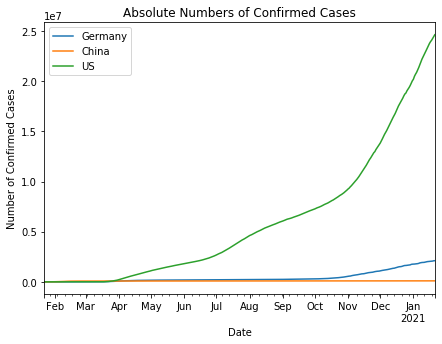

In [8]:
# Absolute Numbers of Confirmed Cases
df_confirmed_abs = create_df("Confirmed")
df_confirmed_abs = format_date(df_confirmed_abs)
plot(df_confirmed_abs, 'Absolute Numbers of Confirmed Cases', 'Number of Confirmed Cases')

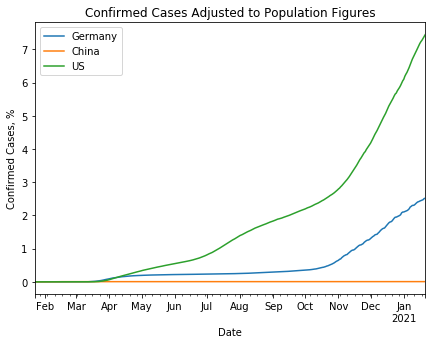

In [9]:
# Confirmed Cases Adjusted to Population Figures
df_confirmed_rel = create_df("Confirmed")

df_confirmed_rel["Germany"] = df_confirmed_rel["Germany"] * 100 / POPULATION_GERMANY
df_confirmed_rel["China"] = df_confirmed_rel["China"] * 100 / POPULATION_CHINA
df_confirmed_rel["US"] = df_confirmed_rel["US"] * 100 / POPULATION_US

df_confirmed_rel = format_date(df_confirmed_rel)
plot(df_confirmed_rel, 'Confirmed Cases Adjusted to Population Figures', 'Confirmed Cases, %')

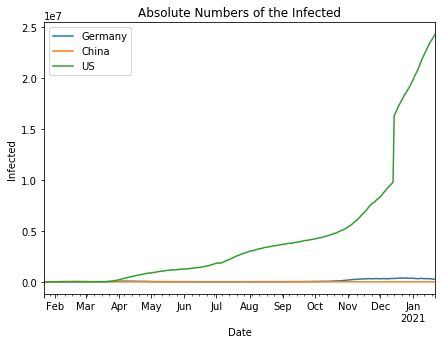

In [10]:
# Absolute Numbers of the Infected
df_infected_abs = create_df("Confirmed")

df_infected_abs["Germany"] = df_infected_abs["Germany"] - df_Germany["Recovered"] - df_Germany["Deaths"]
df_infected_abs["China"] = df_infected_abs["China"] - df_China["Recovered"] - df_China["Deaths"]
df_infected_abs["US"] = df_infected_abs["US"] - df_US["Recovered"] - df_US["Deaths"]

df_infected_abs = format_date(df_infected_abs)
plot(df_infected_abs, 'Absolute Numbers of the Infected', 'Infected')

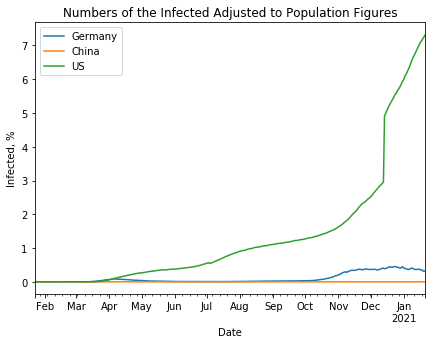

In [11]:
# Numbers of the Infected Adjusted to Population Figures
df_infected_rel = create_df("Confirmed")

df_infected_rel["Germany"] = (df_infected_rel["Germany"] - df_Germany["Recovered"] - df_Germany["Deaths"]) * 100 / POPULATION_GERMANY
df_infected_rel["China"] = (df_infected_rel["China"] - df_China["Recovered"] - df_China["Deaths"]) * 100 / POPULATION_CHINA
df_infected_rel["US"] = (df_infected_rel["US"] - df_US["Recovered"] - df_US["Deaths"]) * 100 / POPULATION_US

df_infected_rel = format_date(df_infected_rel)
plot(df_infected_rel, 'Numbers of the Infected Adjusted to Population Figures', 'Infected, %')

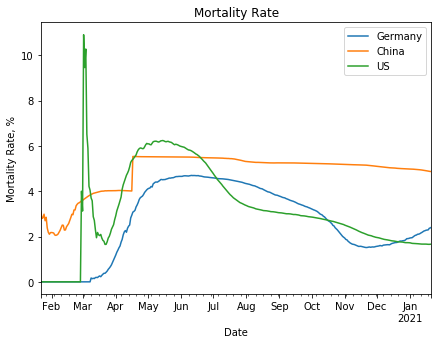

In [12]:
# Mortality Rate
df_mortality_rate = create_df("Deaths")

df_mortality_rate["Germany"] = df_mortality_rate["Germany"] / df_Germany["Confirmed"] * 100 
df_mortality_rate["Germany"] = df_mortality_rate["Germany"].fillna(0)
df_mortality_rate["China"] = df_mortality_rate["China"] / df_China["Confirmed"] * 100 
df_mortality_rate["US"] = df_mortality_rate["US"] / df_US["Confirmed"] * 100

df_mortality_rate = format_date(df_mortality_rate)
plot(df_mortality_rate, 'Mortality Rate', 'Mortality Rate, %')

# Assignment 2 (Clustering)

In [13]:
# downloaded from see Reference 5
df_population = pd.read_csv('csvData.csv')

In [14]:
df_population_trimmed = df_population[['name', 'pop2020']].copy()
df_population_trimmed['name'] = df_population_trimmed['name'].replace({'United States': 'US', 'Ivory Coast': 'Cote d\'Ivoire',
                                'South Korea': 'Korea, South', 'Czech Republic': 'Czechia'})
df_population_trimmed = df_population_trimmed.append([{'name': 'Congo (Brazzaville)', 'pop2020': 1284.609}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'Congo (Kinshasa)', 'pop2020': 7785.965}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'Kosovo', 'pop2020': 1810.366}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'Taiwan*', 'pop2020': 23816.775}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'Eswatini', 'pop2020': 1160.164}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'Burma', 'pop2020': 54409.800}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'Cabo Verde', 'pop2020': 555.987}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'North Macedonia', 'pop2020': 2083.374}], ignore_index=True)
df_population_trimmed = df_population_trimmed.append([{'name': 'West Bank and Gaza', 'pop2020': 5163.374}], ignore_index=True)
df_population_trimmed["pop2020"] = df_population_trimmed["pop2020"] * 1000

In [15]:
df_dropped = df[(df['Country'] != 'Holy See') 
               & (df['Country'] != 'Diamond Princess')
               & (df['Country'] != 'MS Zaandam') 
               & (df['Country'] != 'Micronesia')]

In [16]:
df_joined = df_dropped.set_index('Country').join(df_population_trimmed.set_index('name'))
infected_df = df_joined
infected_df.insert(loc=1, column='Infected', value=0)
infected_df["Infected"] = (infected_df["Confirmed"] - infected_df["Recovered"] 
                                   - infected_df["Deaths"]) * 100 / infected_df["pop2020"]
infected_reshaped_df = infected_df.pivot(columns="Date", values="Infected")
infected_reshaped_df.head()

Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2021-01-19,2021-01-20,2021-01-21
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017147,0.016525,0.015832,0.015600,0.015765,0.014840,0.013769,0.013463,0.013268,0.013237
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.867122,0.876295,0.885643,0.894608,0.898465,0.902079,0.897596,0.897110,0.902704,0.910210
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068908,0.068984,0.069127,0.069248,0.069342,0.069424,0.069565,0.069702,0.069850,0.069909
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.861969,0.855497,0.891736,0.960331,1.075519,1.084579,1.084579,0.974568,1.057400,1.050929
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007330,0.007211,0.006633,0.006484,0.006417,0.006365,0.005507,0.005315,0.005258,0.004725


In [17]:
def determine_optimal_number_of_pca_components(df, pca_components):
    pca = decomposition.PCA(pca_components)
    pca.fit(df)
    variance_loss, variance_ratio, pca_components = pca_2_components(df)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(np.linspace(1, 10, 10), np.cumsum(pca.explained_variance_ratio_), c='teal')
    ax.set_title('Cumulative Explained Variance \n First two components explain {}% of the variance \n By projecting to 2D the model will experience \n {}% variance loss'.
                 format(variance_ratio, variance_loss))
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Variance Explained') 
    
def pca_2_components(df):   
    pca = decomposition.PCA(2)
    pca.fit(df)
    pca_components = pca.transform(df)
    variance_loss = round(((1 - pca.explained_variance_ratio_.sum()) * 100), 2)
    variance_ratio = round(pca.explained_variance_ratio_.sum(), 3)
    return variance_loss, variance_ratio, pca_components

def plot_2_principal_components(pca_components):
    df_pca_components = pd.DataFrame(pca_components)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(df_pca_components[0], df_pca_components[1], c='teal', alpha=0.5)
    ax.set_title('Plot of First two Principal Components')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2') 
    return df_pca_components
    
# Code of the method is based on Reference 4         
def determine_optimal_number_of_clusters(df_pca_components):
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    inertia = []
    silhouette = []
    
    for n in clusters:
        model = KMeans(n_clusters=n)
        labels = model.fit_predict(df_pca_components)
        inertia.append(model.inertia_)
        silhouette_avg = silhouette_score(df_pca_components, labels)
        silhouette.append(silhouette_avg)  

    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 5))
    ax0.plot(clusters, inertia, c='teal')
    ax0.set_title('Inertia')
    ax0.annotate('Elbow', xy=(3, inertia[1]), xytext=(0.2, 0.6), textcoords='figure fraction', fontsize=15,
            arrowprops=dict(facecolor='black', shrink=0.1))
    ax0.set_xlabel('Number of clusters')
    ax0.set_ylabel('Inertia')
    
    ax1.plot(range(2, 11), silhouette, c='teal')
    ax1.annotate('Large enough score', xy=(3, silhouette[1]), xytext=(0.7, 0.7), textcoords='figure fraction', fontsize=15,
            arrowprops=dict(facecolor='black', shrink=0.1))
    ax1.set_title('Silhouette score')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette score') 
        
def kmeans_clustering(number_of_clusters, df_pca_components):
    kmeans = KMeans(n_clusters=number_of_clusters)
    y_pred = kmeans.fit_predict(df_pca_components)
    df_y_pred = pd.DataFrame(y_pred)
    LABEL_COLOR_MAP = {0: 'dodgerblue', 1: 'magenta', 2: 'goldenrod'} 
    label_color = [LABEL_COLOR_MAP[l] for l in y_pred]
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(df_pca_components[0], df_pca_components[1], c=label_color, alpha=1)
    ax.set_title('Visualization of Clustering Results') 
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    return df_y_pred

def prepare_dfs_for_3_clusters(df, df_labels, df_infected):
    df_country = df.groupby('Country').sum().reset_index()
    df_country = df_country['Country']
    df_concat = pd.concat([df_country, df_labels], axis=1)
    df_concat.columns = ['Country', 'Labels']
    df_concat = df_concat.set_index('Country')
    df_infected_reshaped_with_labels = pd.concat([df_infected, df_concat], axis=1)
    
    df_0 = df_infected_reshaped_with_labels[(df_infected_reshaped_with_labels['Labels']) == 0]
    df_1 = df_infected_reshaped_with_labels[(df_infected_reshaped_with_labels['Labels']) == 1]
    df_2 = df_infected_reshaped_with_labels[(df_infected_reshaped_with_labels['Labels']) == 2]
    
    df_0 = df_0.drop(columns=['Labels'])
    df_1 = df_1.drop(columns=['Labels'])
    df_2 = df_2.drop(columns=['Labels'])
    return df_0, df_1, df_2

def plot_cluster_1(df_0):    
    df_0 = pd.DataFrame(df_0.mean(axis=0))
    df_0.columns = ['Average']
    df_0.index.name = 'Date'
    df_0 = df_0.reset_index()
    df_Belarus = pd.DataFrame(infected_reshaped_df.loc["Belarus"])
    df_Belarus = df_Belarus.reset_index()
    df_Colombia = pd.DataFrame(infected_reshaped_df.loc["Colombia"])
    df_Colombia = df_Colombia.reset_index()
    df_China_clustering = pd.DataFrame(infected_reshaped_df.loc["China"])
    df_China_clustering = df_China_clustering.reset_index()
    df_Germany_clustering = pd.DataFrame(infected_reshaped_df.loc["Germany"])
    df_Germany_clustering = df_Germany_clustering.reset_index()
    df_cluster_0 = pd.concat([df_0['Date'], df_Belarus['Belarus'], 
                              df_Colombia['Colombia'], df_China_clustering['China'], df_0['Average'], df_Germany_clustering['Germany']], axis=1, keys=['Date', 'Belarus', 'Colombia', 'China', 'Average', 'Germany'])
    df_formatted_for_cluster_0 = format_date(df_cluster_0)
    plot_cluster(df_formatted_for_cluster_0, 'Cluster 1')
        
def plot_cluster_2(df_1):  
    df_1 = pd.DataFrame(df_1.mean(axis=0))
    df_1.columns = ['Average']
    df_1.index.name = 'Date'
    df_1 = df_1.reset_index()
    df_France = pd.DataFrame(infected_reshaped_df.loc["France"])
    df_France = df_France.reset_index()
    df_US = pd.DataFrame(infected_reshaped_df.loc["US"])
    df_US = df_US.reset_index()
    df_United_Kingdom = pd.DataFrame(infected_reshaped_df.loc["United Kingdom"])
    df_United_Kingdom = df_United_Kingdom.reset_index()
    df_cluster_1 = pd.concat([df_1['Date'], df_France['France'], 
                              df_US['US'], df_United_Kingdom['United Kingdom'], df_1['Average']], axis=1, keys=['Date', 'France', 'US', 'United Kingdom', 'Average'])
    df_formatted_for_cluster_1 = format_date(df_cluster_1)
    plot_cluster(df_formatted_for_cluster_1, 'Cluster 2')
    
def plot_cluster_3(df_2): 
    df_2 = pd.DataFrame(df_2.mean(axis=0))
    df_2.columns = ['Average']
    df_2.index.name = 'Date'
    df_2 = df_2.reset_index()
    df_Canada = pd.DataFrame(infected_reshaped_df.loc["Canada"])
    df_Canada = df_Canada.reset_index()
    df_Czechia = pd.DataFrame(infected_reshaped_df.loc["Czechia"])
    df_Czechia = df_Czechia.reset_index()
    df_Hungary = pd.DataFrame(infected_reshaped_df.loc["Hungary"])
    df_Hungary = df_Hungary.reset_index()
    df_cluster_2 = pd.concat([df_2['Date'], df_Canada['Canada'], 
                              df_Czechia['Czechia'], df_Hungary['Hungary'], df_2['Average']], axis=1, keys=['Date', 'Canada', 'Czechia', 'Hungary', 'Average'])
    df_formatted_for_cluster_2 = format_date(df_cluster_2)
    plot_cluster(df_formatted_for_cluster_2, 'Cluster 3')    
      
def plot_cluster(df, title):
    fig, ax = plt.subplots(figsize=(7, 5))
    df.plot(ax=ax) 
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Infected, %')

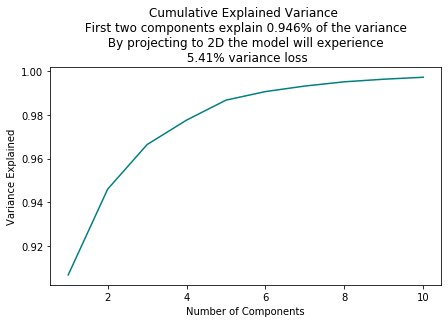

In [18]:
determine_optimal_number_of_pca_components(infected_reshaped_df, 10)

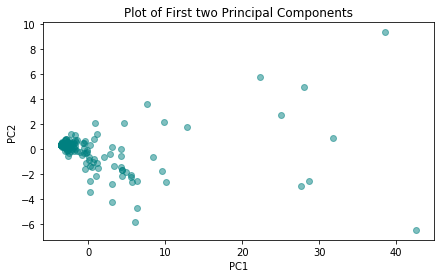

In [19]:
variance_loss, variance_ratio, pca_components = pca_2_components(infected_reshaped_df)
df_pca_components = plot_2_principal_components(pca_components)

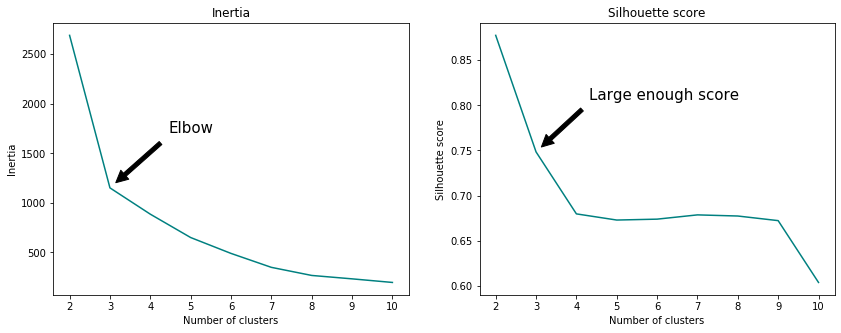

In [20]:
determine_optimal_number_of_clusters(df_pca_components)

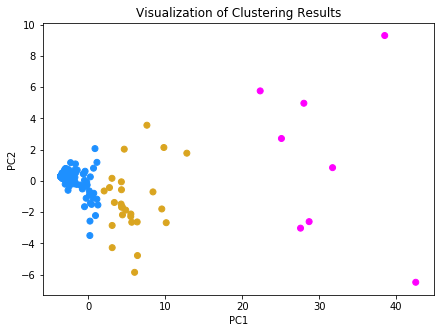

In [21]:
df_y_pred = kmeans_clustering(3, df_pca_components)

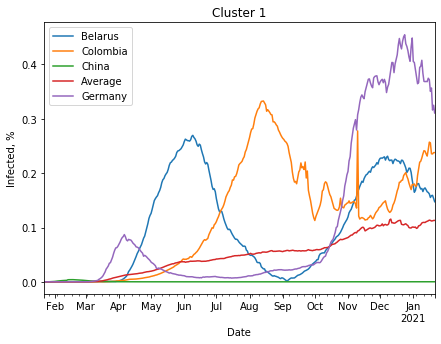

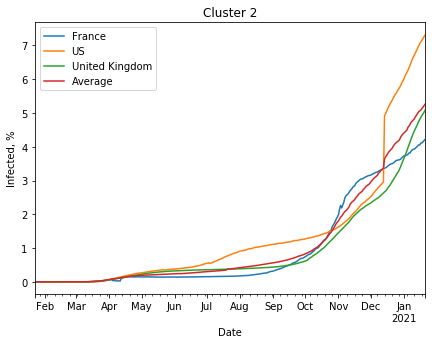

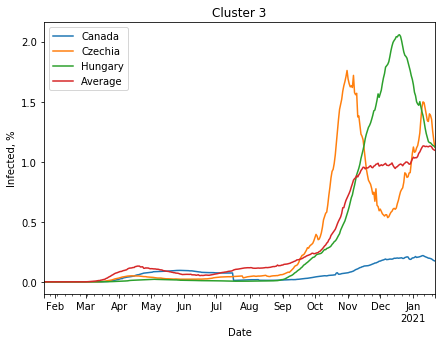

In [22]:
df_0, df_1, df_2 = prepare_dfs_for_3_clusters(df_dropped, df_y_pred, infected_reshaped_df)
plot_cluster_1(df_0)
plot_cluster_2(df_1)
plot_cluster_3(df_2)

# Assignment 3 (Modelling)
## Germany / China
## Linear Model (train_test split for time series)

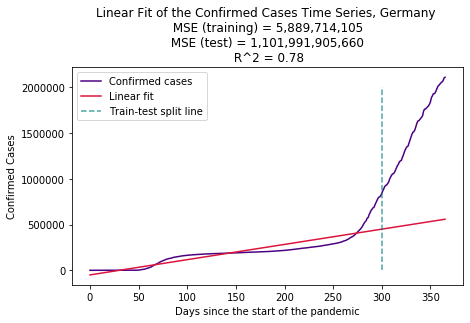

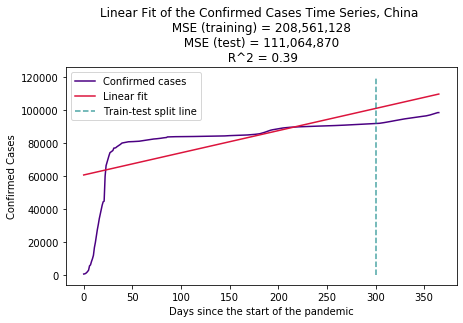

In [23]:
# Split the data into a train(ten months, ca.80%) and test(two months, ca.20%) sets
TEST_SET = 66
TRAIN_TEST_SPLIT_LINE = 300
SPLIT_LINE_GERMANY = 2000000
SPLIT_LINE_CHINA = 120000

def extract_data(df):
    X = df.index.values.reshape(-1, 1)
    y = df['Confirmed']
    return X, y

def split_train_test_for_time_series(X, y):
    X_train, y_train = X[0:len(X) - TEST_SET], y[0:len(y) - TEST_SET]
    X_test, y_test = X[len(X)-TEST_SET:], y[len(y) - TEST_SET:]
    return X_train, y_train, X_test, y_test

def fit_linear_model_calculate_metrics(X_train, y_train, X_test, y_test):
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train) 
    y_train_pred = lin_model.predict(X_train)
    y_test_pred = lin_model.predict(X_test)
    r_squared = round(lin_model.score(X_train, y_train), 2)
    mse_training = format(int(round(mean_squared_error(y_train, y_train_pred), 0)), ",")
    mse_test = format(int(round(mean_squared_error(y_test, y_test_pred), 0)), ",")
    return lin_model, r_squared, mse_training, mse_test
    
def plot_linear_model(X, y, lin_model, country, mse_training, mse_test, r_squared, split_line):
    X_linplot = [[X.min()], [X.max()]]
    y_linplot = lin_model.predict(X_linplot)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(X, y, c='indigo')
    ax.plot(X_linplot, y_linplot, c='crimson')
    X_train_test_split_line = [[TRAIN_TEST_SPLIT_LINE], [TRAIN_TEST_SPLIT_LINE]]
    y_train_test_split_line = [[0], [split_line]]
    ax.plot(X_train_test_split_line, y_train_test_split_line, ls='--', c='teal', alpha=0.7)
    ax.set_title("Linear Fit of the Confirmed Cases Time Series, {} \n MSE (training) = {} \n MSE (test) = {} \n R^2 = {}".format(
             country, mse_training, mse_test, r_squared))
    ax.legend(('Confirmed cases', 'Linear fit', 'Train-test split line'), loc='upper left')
    ax.set_xlabel('Days since the start of the pandemic')
    ax.set_ylabel('Confirmed Cases')
    
X_G, y_G = extract_data(df_Germany)
X_train_G, y_train_G, X_test_G, y_test_G = split_train_test_for_time_series(X_G, y_G)
germany_lin_model, r_squared_G, mse_training_G, mse_test_G = fit_linear_model_calculate_metrics(X_train_G, y_train_G, X_test_G, y_test_G)
plot_linear_model(X_G, y_G, germany_lin_model, "Germany", mse_training_G, mse_test_G, r_squared_G, SPLIT_LINE_GERMANY)

X_C, y_C = extract_data(df_China)
X_train_C, y_train_C, X_test_C, y_test_C = split_train_test_for_time_series(X_C, y_C)
china_lin_model, r_squared_C, mse_training_C, mse_test_C = fit_linear_model_calculate_metrics(X_train_C, y_train_C, X_test_C, y_test_C)
plot_linear_model(X_C, y_C, china_lin_model, "China", mse_training_C, mse_test_C, r_squared_C, SPLIT_LINE_CHINA)

## Polynomial Regression (random train_test and cross_validation splits)

In [24]:
def split_train_test_random(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    return X_train, y_train, X_test, y_test

# Code of the method is based on Reference 1
def polynomial_model_random_splits(X_train, y_train):
    degrees = list(range(1, 16))
    
    mse_mean = []
    mse_std = []
    r2_mean = []
    r2_std = []
    
    for i in range(len(degrees)):
        polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
        pipeline.fit(X_train, y_train)
        
        r2_score = round(pipeline.score(X_train, y_train), 4)
        
        y_predict = pipeline.predict(X_train)
        mse = format(int(round(mean_squared_error(y_train, y_predict), 0)), ",")
        
        scores_r2 = cross_val_score(pipeline, X_train, y_train, cv=10)
        scores_mse = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
        
        mse_mean.append(-scores_mse.mean())
        mse_std.append(scores_mse.std())
        r2_mean.append(scores_r2.mean())  
        r2_std.append(scores_r2.std())
        
        print("Degree {}: R^2_mean(CV) = {}; R^2_std(CV) = {}; R^2(on train set, without CV) = {}".format(
            degrees[i], round(scores_r2.mean(), 4), round(scores_r2.std(), 4), r2_score))
        print("Degree {}: MSE_mean(CV) = {}; MSE_std(CV) = {}; MSE(on train set, without CV) = {}".format(
            degrees[i], format(int(round(-scores_mse.mean(), 0)), ","), format(int(round(scores_mse.std(), 0)), ","), mse))
        
    return degrees, mse_mean, mse_std, r2_mean, r2_std
        
def polynomial_model_plot_scores(country, best_degree, degrees, mse_mean, mse_std, r2_mean, r2_std, smallest_mse_mean, smallest_mse_std, highest_r2_mean, smallest_r2_std):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    ax0.plot(degrees, mse_mean, c='indigo')
    ax0.plot(degrees, mse_std, c='crimson')
    ax0.set_title("Cross Validation Scores (MSE), {} \n Best (smallest) MSE = {} \n (+/- {}) \n is reached at degree {}".format(
             country, smallest_mse_mean, smallest_mse_std, best_degree))
    ax0.legend(('MSE (mean)', 'MSE (std)'), loc='upper left')
    ax0.set_xlabel('Degrees')
    ax0.set_ylabel('MSE')
    
    ax1.plot(degrees, r2_mean, c='teal')
    ax1.plot(degrees, r2_std, c='y')
    ax1.set_title("Cross Validation Scores (R^2), {} \n Best (closest to 1) R^2 = {} \n (+/- {}) \n is reached at degree {}".format(
             country, highest_r2_mean, smallest_r2_std, best_degree))
    ax1.legend(('R^2 (mean)', 'R^2 (std)'), loc='upper right')
    ax1.set_xlabel('Degrees')
    ax1.set_ylabel('R^2')
    
def evaluate_performance_on_test_set(best_degree, X_train, y_train, X_test, y_test):
    polynomial_features = PolynomialFeatures(degree=best_degree,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train, y_train)
    y_predictions_test = pipeline.predict(X_test)
    test_mse = format(int(round(mean_squared_error(y_test, y_predictions_test), 0)), ",")
    print("Test MSE: {}".format(test_mse))
    return test_mse
    
# Code of the method is based on Reference 2    
def polynomial_model_plot_best_degree(country, best_degree, X_train, y_train, X, y, mse_mean, test_mse):
    polynomial_features = PolynomialFeatures(degree=best_degree, include_bias=False)
    X_poly_train = polynomial_features.fit_transform(X_train)
    lin_poly = LinearRegression()
    lin_poly.fit(X_poly_train, y_train)
    X_poly = polynomial_features.transform(X)
    y_poly = lin_poly.predict(X_poly)
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(X, y, c='indigo')
    ax.plot(X, y_poly, c='crimson')
    ax.set_xlabel('Days since the start of the pandemic')
    ax.set_ylabel('Confirmed Cases')
    ax.legend(('Confirmed cases', 'Model, degree {}'.format(best_degree)), loc="lower right")
    ax.set_title("Polynomial Model Degree {}, {} \n MSE(cross validation on train set) = {} \n MSE(on test set) = {}".format(
        best_degree, country, mse_mean, test_mse))

### Germany

In [25]:
X_train_G_random, y_train_G_random, X_test_G_random, y_test_G_random = split_train_test_random(X_G, y_G)
degrees_G, mse_mean_G, mse_std_G, r2_mean_G, r2_std_G = polynomial_model_random_splits(X_train_G_random, y_train_G_random)

Degree 1: R^2_mean(CV) = 0.6412; R^2_std(CV) = 0.0774; R^2(on train set, without CV) = 0.6605
Degree 1: MSE_mean(CV) = 111,776,632,742; MSE_std(CV) = 19,234,424,795; MSE(on train set, without CV) = 110,434,206,898
Degree 2: R^2_mean(CV) = 0.8874; R^2_std(CV) = 0.0376; R^2(on train set, without CV) = 0.8973
Degree 2: MSE_mean(CV) = 33,992,271,474; MSE_std(CV) = 4,431,649,843; MSE(on train set, without CV) = 33,422,531,625
Degree 3: R^2_mean(CV) = 0.984; R^2_std(CV) = 0.0076; R^2(on train set, without CV) = 0.986
Degree 3: MSE_mean(CV) = 4,717,286,137; MSE_std(CV) = 1,130,227,292; MSE(on train set, without CV) = 4,551,737,800
Degree 4: R^2_mean(CV) = 0.9901; R^2_std(CV) = 0.0024; R^2(on train set, without CV) = 0.991
Degree 4: MSE_mean(CV) = 3,100,703,648; MSE_std(CV) = 765,928,865; MSE(on train set, without CV) = 2,927,856,058
Degree 5: R^2_mean(CV) = 0.9952; R^2_std(CV) = 0.0018; R^2(on train set, without CV) = 0.9958
Degree 5: MSE_mean(CV) = 1,434,193,102; MSE_std(CV) = 298,570,580; M

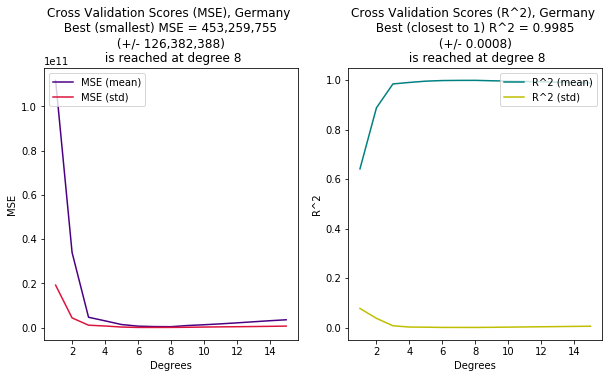

In [26]:
polynomial_model_plot_scores("Germany", 8, degrees_G, mse_mean_G, mse_std_G, r2_mean_G, r2_std_G, "453,259,755", "126,382,388", "0.9985", "0.0008")

In [27]:
test_mse_G = evaluate_performance_on_test_set(8, X_train_G_random, y_train_G_random, X_test_G_random, y_test_G_random)

Test MSE: 540,299,863


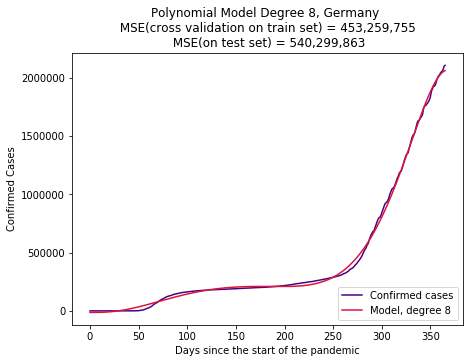

In [28]:
polynomial_model_plot_best_degree("Germany", 8, X_train_G_random, y_train_G_random, X_G, y_G, "453,259,755", test_mse_G)

### China

In [29]:
X_train_C_random, y_train_C_random, X_test_C_random, y_test_C_random = split_train_test_random(X_C, y_C)
degrees_C, mse_mean_C, mse_std_C, r2_mean_C, r2_std_C = polynomial_model_random_splits(X_train_C_random, y_train_C_random)

Degree 1: R^2_mean(CV) = 0.1226; R^2_std(CV) = 0.5025; R^2(on train set, without CV) = 0.4361
Degree 1: MSE_mean(CV) = 177,622,391; MSE_std(CV) = 131,962,668; MSE(on train set, without CV) = 172,075,781
Degree 2: R^2_mean(CV) = 0.0576; R^2_std(CV) = 0.8102; R^2(on train set, without CV) = 0.5825
Degree 2: MSE_mean(CV) = 134,178,136; MSE_std(CV) = 78,797,792; MSE(on train set, without CV) = 127,412,130
Degree 3: R^2_mean(CV) = 0.2231; R^2_std(CV) = 0.9022; R^2(on train set, without CV) = 0.7446
Degree 3: MSE_mean(CV) = 83,181,369; MSE_std(CV) = 39,156,709; MSE(on train set, without CV) = 77,933,271
Degree 4: R^2_mean(CV) = 0.4962; R^2_std(CV) = 0.6102; R^2(on train set, without CV) = 0.8614
Degree 4: MSE_mean(CV) = 45,112,972; MSE_std(CV) = 16,426,137; MSE(on train set, without CV) = 42,287,217
Degree 5: R^2_mean(CV) = 0.7781; R^2_std(CV) = 0.2717; R^2(on train set, without CV) = 0.9432
Degree 5: MSE_mean(CV) = 18,417,335; MSE_std(CV) = 6,278,601; MSE(on train set, without CV) = 17,347,

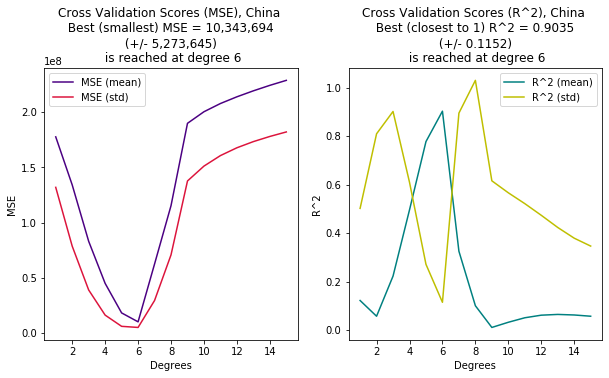

In [30]:
polynomial_model_plot_scores("China", 6, degrees_C, mse_mean_C, mse_std_C, r2_mean_C, r2_std_C, "10,343,694", "5,273,645", "0.9035", "0.1152")

In [31]:
test_mse_C = evaluate_performance_on_test_set(6, X_train_C_random, y_train_C_random, X_test_C_random, y_test_C_random)

Test MSE: 7,944,069


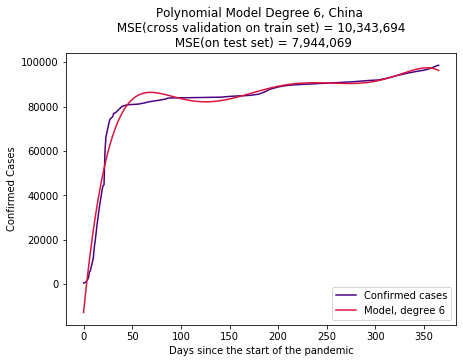

In [32]:
polynomial_model_plot_best_degree("China", 6, X_train_C_random, y_train_C_random, X_C, y_C, "10,343,694", test_mse_C)

## Autoregression

In [33]:
def determine_lag(y):
    autocorrelation_plot(y)
    plot_acf(y, lags=40)
    
def plot_best_lag_correlation(y, best_lag):
    lag_plot(y, lag=best_lag)   
    
# Code of the method is based on Reference 3     
def autoregression_model(country, best_lag, y_train, y_test, dynamic_param, y, split_line):
    autoreg_model = AutoReg(y_train, lags=best_lag, old_names=False)
    autoreg_model_fit = autoreg_model.fit()
    predictions_y = autoreg_model_fit.predict(start=0, end=len(y_train)+len(y_test)-1, dynamic=dynamic_param)
    predictions_y_test = autoreg_model_fit.predict(start=len(y_train_G), end=len(y_train_G)+len(y_test_G)-1, dynamic=dynamic_param)
    test_mse = format(int(round(mean_squared_error(y_test, predictions_y_test), 0)), ",")
       
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 5))
    X_train_test_split_line = [[TRAIN_TEST_SPLIT_LINE], [TRAIN_TEST_SPLIT_LINE]]
    y_train_test_split_line = [[0], [split_line]]
    ax0.plot(X_train_test_split_line, y_train_test_split_line, ls='--', c='teal', alpha=0.7)
    ax0.plot(y, c='indigo')
    ax0.plot(predictions_y, c='crimson')
    ax0.set_title("Autoregressive Model (train and test sets), {} \n MSE (test) = {}".format(country, test_mse))
    ax0.legend(('Confirmed cases', 'Autoregressive Model', 'Train-test split line'), loc='upper left')
    ax0.set_xlabel('Days since the start of the pandemic')
    ax0.set_ylabel('Confirmed Cases')
    
    ax1.plot(y_test, c='indigo')
    ax1.plot(predictions_y_test, c='crimson')
    ax1.set_title("Autoregressive Model (test set only), {} \n MSE (test) = {}".format(country, test_mse))
    ax1.legend(('Confirmed cases', 'Autoregressive Model', 'Train-test split line'), loc='lower right')
    ax1.set_xlabel('Days since the start of the pandemic')
    ax1.set_ylabel('Confirmed Cases')

### Germany

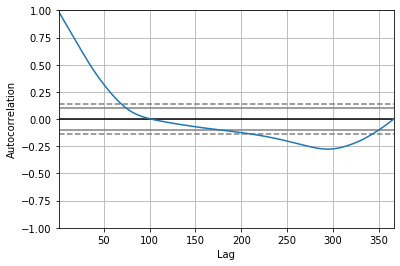

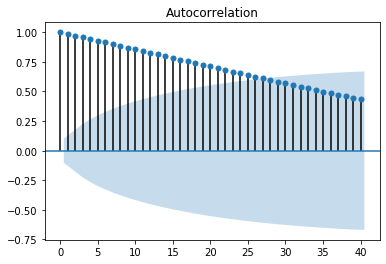

In [34]:
determine_lag(y_G)

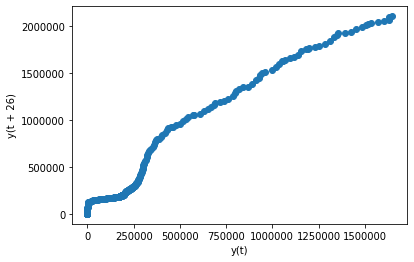

In [35]:
plot_best_lag_correlation(y_G, 26)

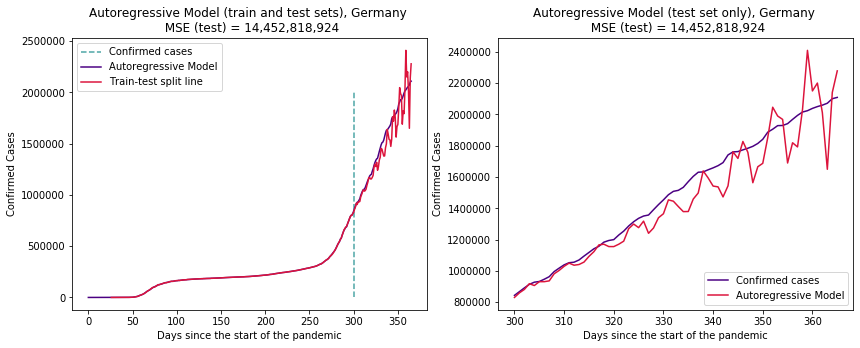

In [36]:
autoregression_model("Germany", 26, y_train_G, y_test_G, False, y_G, SPLIT_LINE_GERMANY)

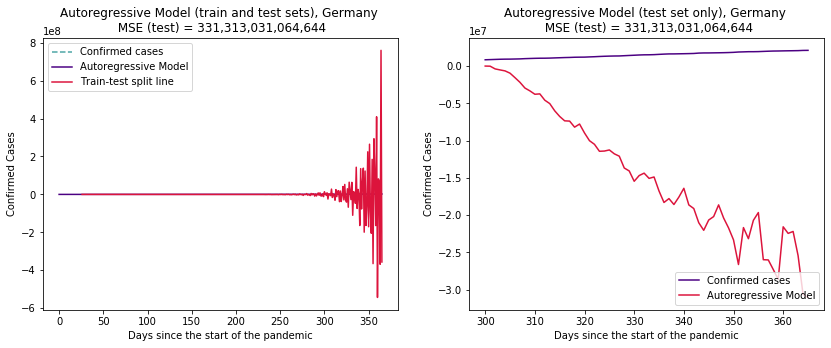

In [37]:
autoregression_model("Germany", 26, y_train_G, y_test_G, True, y_G, SPLIT_LINE_GERMANY)

### China

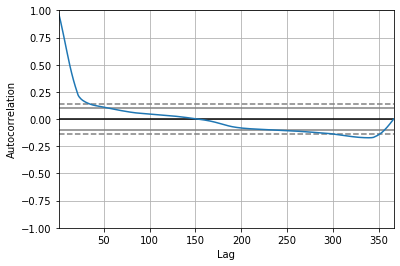

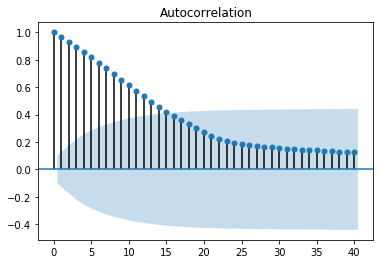

In [38]:
determine_lag(y_C)

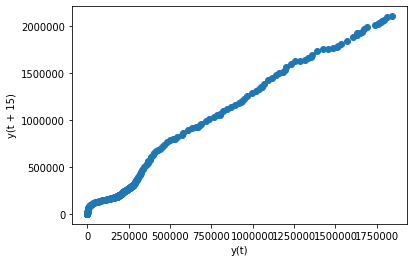

In [39]:
plot_best_lag_correlation(y_G, 15)

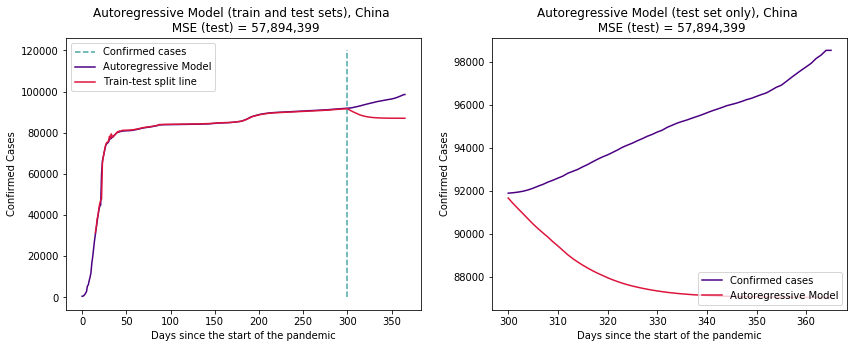

In [40]:
autoregression_model("China", 15, y_train_C, y_test_C, False, y_C, SPLIT_LINE_CHINA)

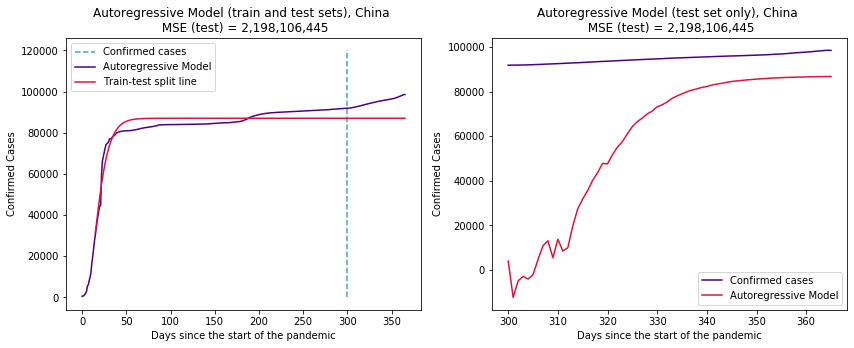

In [41]:
autoregression_model("China", 15, y_train_C, y_test_C, True, y_C, SPLIT_LINE_CHINA)

# References

1. scikit-learn Dokumentation, *Underfitting vs. Overfitting*. [Underfitting vs. Overfitting Code Example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)
2. Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, 2017, p. 162-163. [Chapter 4. Training Linear Models](https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb) 
3. Jason Brownlee, *Autoregression Models for Time Series Forecasting With Python*, August 15, 2020. [Time Series Forecasting With Python](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/) 
4. Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, 2017. [Chapter 8. Dimensionality Reduction and Clustering](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb) 
5. [World Population data](https://worldpopulationreview.com/) downloaded 31.12.2020.
6. Data Hub. Novel Coronavirus 2019. [Aggregated time series data](https://datahub.io/core/covid-19) downloaded 23.01.2021.
7. Aleszu Bajak, *How to use hierarchical cluster analysis on time series data*, December 13, 2019. [Time Series Clustering](https://www.storybench.org/how-to-use-hierarchical-cluster-analysis-on-time-series-data/)